In [1]:
# Developed by Samuel Horovatin at the University of Saskatchewan
# July, 2021
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import os
import os.path
import shutil
import pandas as pd
import numpy as np
import random

from skimage.transform import resize
from skimage.io import imread
from skimage.io import imshow
from sklearn.cluster import KMeans
import cv2

In [121]:
# Base paramaters used by plantcv for image discovery and processing

plt.rcParams["figure.figsize"] = [8, 8]
class options:
    def __init__(self):
        # Input image path/filename
        self.datastore_base_dir = "/datastore/AGILE/BELToutput/LDP_Sebastian"
        self.extention_pattern = ".jpg"
        # Debug mode = None, "plot", or "print"
        self.debug = None #DO NOT SET TO PLOT FOR BIG DATA RUNS.
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "results.txt"
        # Image output directory path
        self.outdir = "/birl2/users/sch923/Thesis/Lentil/output"

# Initialize options
args = options()
# Set PlantCV debug mode to input debug method
pcv.params.debug = args.debug
# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

In [3]:
# Searches for all files with certain pattern in datastore_base_dir

files = []
for dirpath, dirnames, filenames in os.walk(args.datastore_base_dir):
    for filename in [f for f in filenames if f.endswith(args.extention_pattern)]:
        files.append(os.path.join(dirpath, filename))

print(f"=== Found ({len(files)}) files of pattern {args.extention_pattern} ===")

=== Found (701430) files of pattern .jpg ===


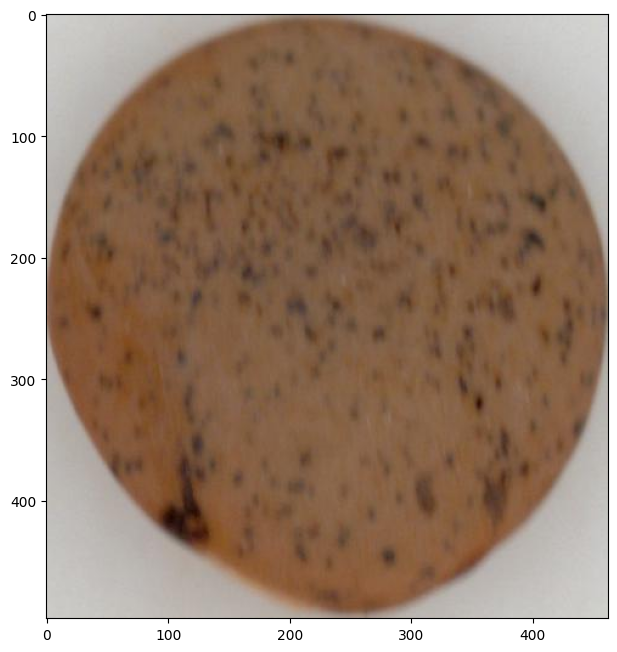

In [105]:
# for lentil_image in os.listdir(args.test_dir):
#     if lentil_image[len(lentil_image)-3:] != 'png':
#         continue
#     img, path, filename = pcv.readimage(filename=args.test_dir+lentil_image)
#     img = pcv.white_balance(img) #Good to normalize the 
#     cs_plot = pcv.visualize.colorspaces(rgb_img=img, original_img=False)
#     s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
#     s_thresh = pcv.threshold.binary(gray_img=s, threshold=60, max_value=255, object_type='light') # threshold is 60 to remove little lentil flecks
#     b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
#     b_thresh = pcv.threshold.binary(gray_img=b, threshold=137, max_value=255, object_type='light')
#     a = pcv.rgb2gray_lab(rgb_img=img, channel='a')
#     a_thresh = pcv.threshold.binary(gray_img=a, threshold=133, max_value=255, object_type='light')
#     bs = pcv.logical_or(bin_img1=s_thresh, bin_img2=b_thresh)
#     bsa = pcv.logical_or(bin_img1=bs, bin_img2=a_thresh)
#     bsa_fill1 = pcv.fill(bin_img=bsa, size=200) # Fill small noise
#     bsa_fill2 = pcv.dilate(gray_img=bsa_fill1, ksize=6, i=2)
#     # bsa_fill3 and bsa_fill4 are to get rid of tiny lentil flakes
#     bsa_fill3 = pcv.erode(bsa_fill2, ksize=12, i=6)
#     bsa_fill4 = pcv.dilate(gray_img=bsa_fill3, ksize=20, i=6) # If no lentil is present, can cause errors
#     # Coppied this check from "fill_holes" source: catches empty images caused by erode and dilate.
#     if len(np.shape(bsa_fill4)) != 2 or len(np.unique(bsa_fill4)) != 2:
#         continue
#     filled_mask1 = pcv.fill_holes(bsa_fill4)

#     id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask1)
#     roi_contour, roi_hierarchy = pcv.roi.rectangle(img, 0, 0, -400, -400)
#     roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi_contour, roi_hierarchy, id_objects, obj_hierarchy)
#     clusters_i, contours, hierarchies = pcv.cluster_contours(img1, roi_objects, roi_obj_hierarchy, 4, 6)
#     # obj, mask = pcv.object_composition(img=img, contours=id_objects, hierarchy=obj_hierarchy)
#     # crop_img = pcv.auto_crop(img=img, obj=obj, padding_x=0, padding_y=0)
#     # pcv.print_image(crop_img, args.outdir+"cropped_"+lentil_image)

IMG_X = 200
IMG_Y = 200
IMG_Z = 3
FILE_LIMITER = 5 # Only used for manual testing in for loop
i = 0

lentil_images=[]
lentil_images_names=[]
image_ROIs=[]

lentil_img_path = random.sample(files, FILE_LIMITER)
img, lentil_img_path, filename = pcv.readimage(filename=lentil_img_path[0])

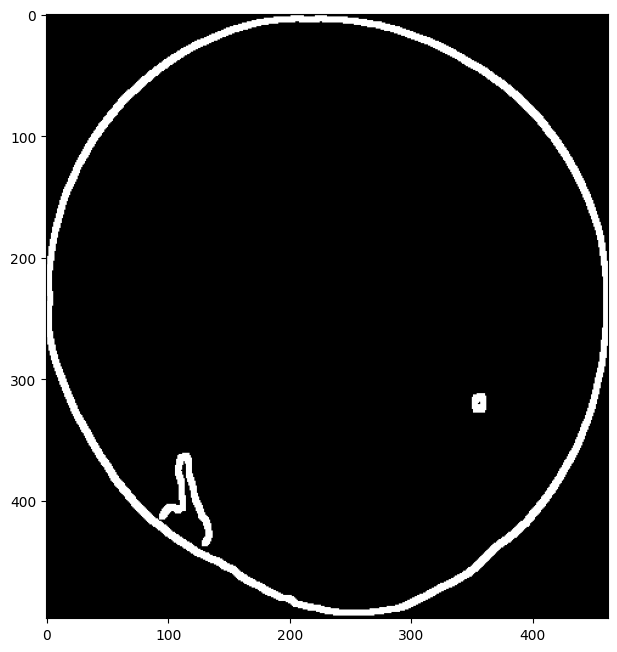

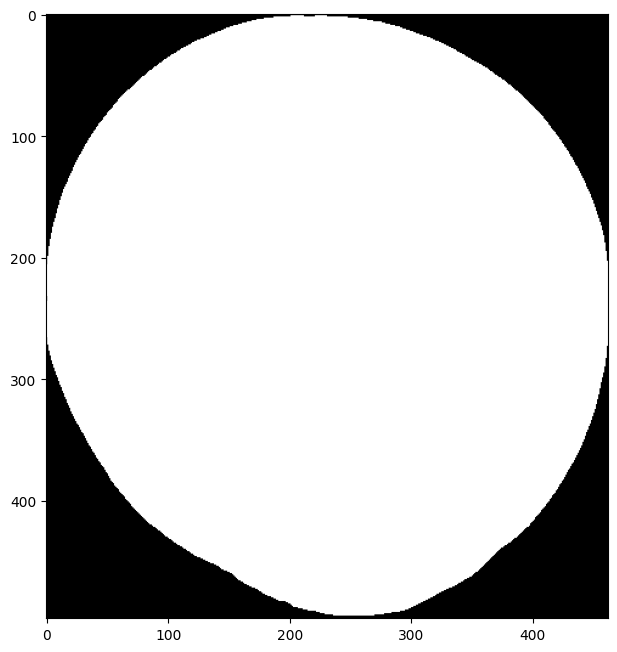

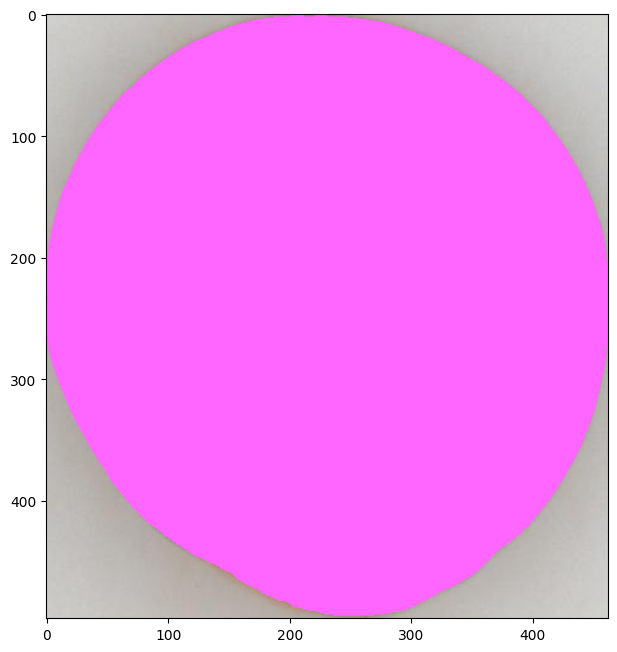

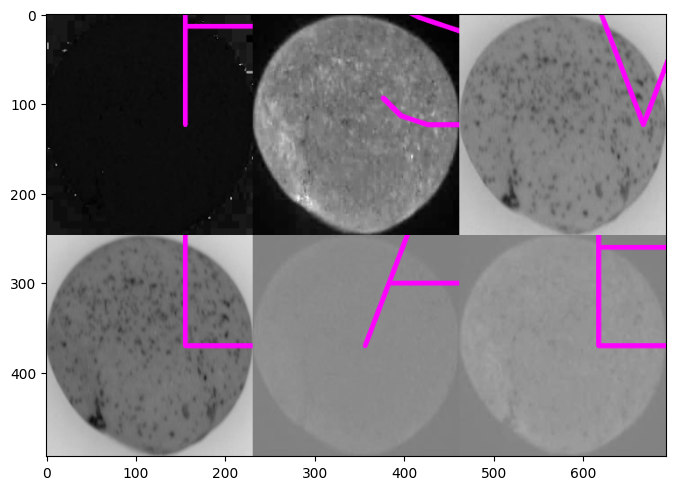

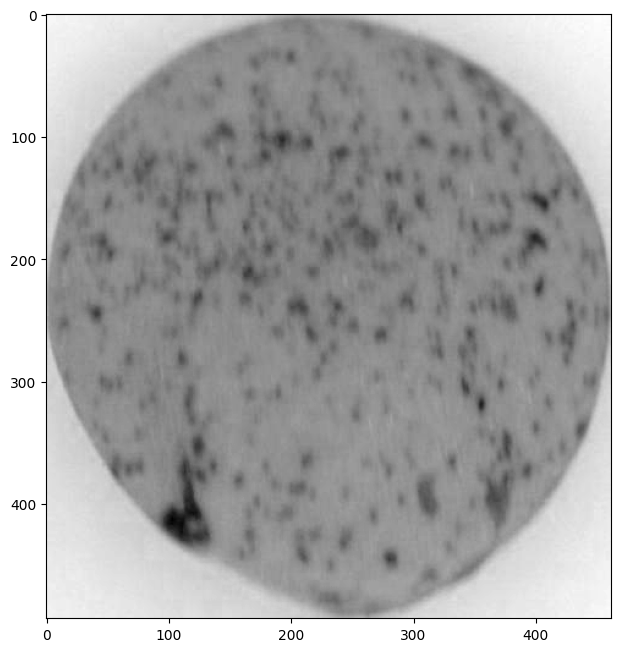

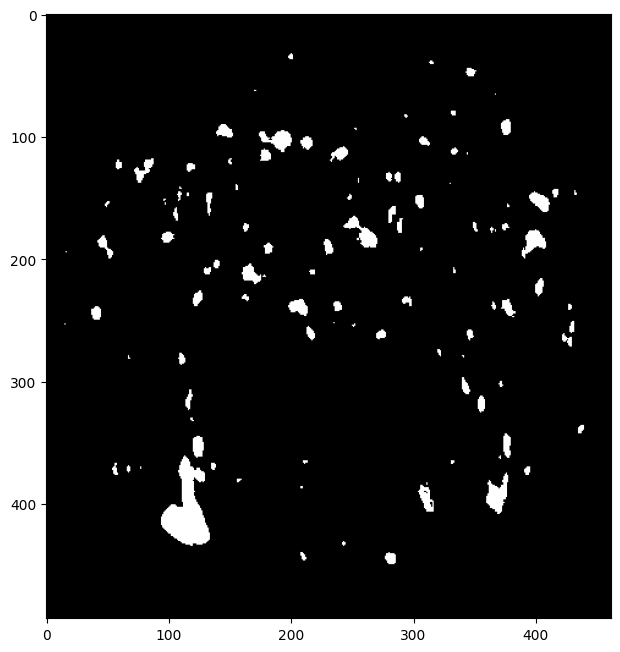

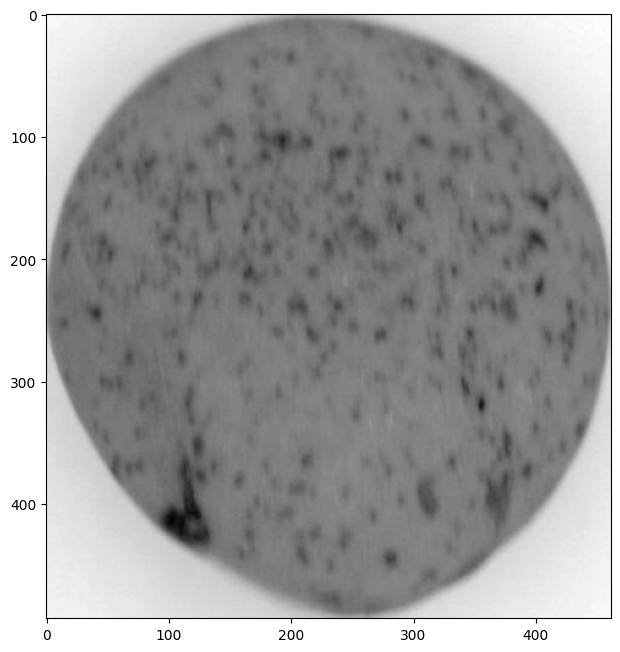

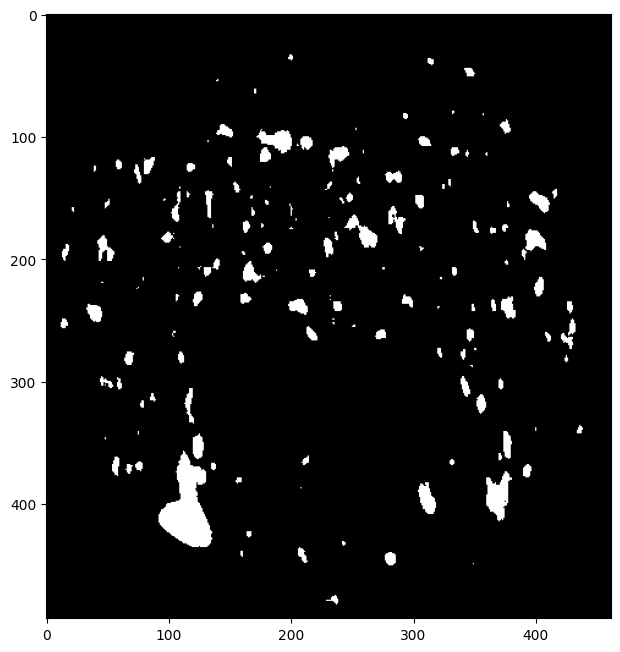

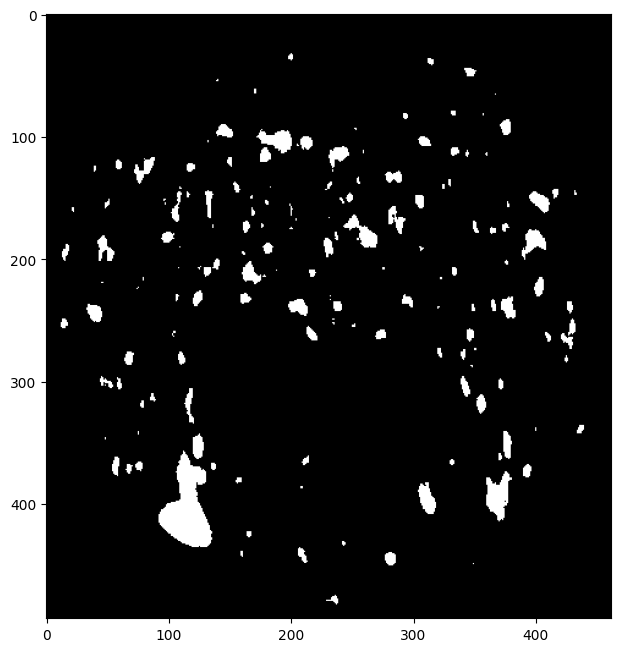

In [114]:
# Segmentation of lentil for color averaging
edges = pcv.canny_edge_detect(img=img, sigma=2.5, low_thresh=0.5, thickness=5)
mask = pcv.fill_holes(edges)
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=mask)
(x, y, w, h) = cv2.boundingRect(id_objects[0])
image_ROI = img[y:y + h, x:x + w]
mask_ROI = mask[y:y + h, x:x + w]

# Color analysis and averaging
cs_plot = pcv.visualize.colorspaces(rgb_img=image_ROI, original_img=False)
v = pcv.rgb2gray_hsv(rgb_img=image_ROI, channel='v')
v_thresh = pcv.threshold.binary(gray_img=v, threshold=np.average(v)-40, max_value=255, object_type='dark')
l = pcv.rgb2gray_lab(rgb_img=image_ROI, channel='l')
l_thresh = pcv.threshold.binary(gray_img=l, threshold=np.average(l)-40, max_value=255, object_type='dark')
vl = pcv.logical_or(bin_img1=v_thresh, bin_img2=l_thresh)
img_resized=resize(vl,(IMG_X, IMG_Y, IMG_Z))

In [144]:
# Bulk proccesses all found images, flattens them, and loads them int array for training

IMG_X = 200
IMG_Y = 200
IMG_Z = 3
FILE_LIMITER = 1000 # Only used for manual testing in for loop
i = 0

lentil_images=[]
lentil_images_names=[]
image_ROIs=[]

for lentil_img_path in random.sample(files, FILE_LIMITER):
    try:
        img, lentil_img_path, filename = pcv.readimage(filename=lentil_img_path)
        
    except:
        print(f"Error opening file: {lentil_img_path}")
        continue
    
    # Pre-processing
    # Segmentation of lentil for color averaging
    # edges = pcv.canny_edge_detect(img=img, sigma=2.5, low_thresh=0.5, thickness=5)
    # mask = pcv.fill_holes(edges)
    # id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=mask)
    # (x, y, w, h) = cv2.boundingRect(id_objects[0])
    # image_ROI = img[y:y + h, x:x + w]
    # mask_ROI = mask[y:y + h, x:x + w]

    # Color analysis and averaging
    v = pcv.rgb2gray_hsv(rgb_img=img, channel='v')
    v_thresh = pcv.threshold.binary(gray_img=v, threshold=np.average(v)-30, max_value=255, object_type='dark')
    l = pcv.rgb2gray_lab(rgb_img=img, channel='l')
    l_thresh = pcv.threshold.binary(gray_img=l, threshold=np.average(l)-30, max_value=255, object_type='dark')
    vl = pcv.logical_or(bin_img1=v_thresh, bin_img2=l_thresh)
    img_resized=resize(vl,(IMG_X, IMG_Y))
    
    
    lentil_images.append(img_resized.flatten())
    lentil_images_names.append(os.path.join(lentil_img_path, filename))
 
print(f"Loaded ({len(lentil_images)}) image files")

Loaded (1000) image files


In [145]:
# Trains n number of k-mean models, with increment of n = k of the model

kMax = min(10, len(lentil_images))
kMin = 2 # Having K = 1 is a waste of time
lentil_kmean_models = []
wcss = [] # For 'within cluster sum of squares' calcuation, which is used to guage correct K value.
# Fits KMean to data using multiple values for K
for k in range(kMin, kMax):
    print(f"========= Training k={k}... =========")
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(lentil_images)
    wcss.append(model.inertia_)
    lentil_kmean_models.append(model)

print(f"========= Training Complete! K-Means Models Trained = {kMax-kMin}... =========")    

1000
(40000,)
========= Training k=2... =========
========= Training k=3... =========
========= Training k=4... =========
========= Training k=5... =========
========= Training k=6... =========
========= Training k=7... =========
========= Training k=8... =========
========= Training k=9... =========
========= Training Complete! K-Means Models Trained = 8... =========


In [ ]:
# Trains t-SNE models


In [148]:
k = kMin
prediction_df = pd.DataFrame(columns=['img', 'k', 'group_pred']) 

for model in lentil_kmean_models:
    model_pred = model.predict(lentil_images)
    for name, pred in zip(lentil_images_names, model_pred):
        prediction_df = prediction_df.append({'img': name, 'k': k, 'group_pred': pred }, ignore_index=True)
    k = k + 1

prediction_df.to_csv("pattern_1000_new.csv", encoding='utf-8', sep=',', index=False)

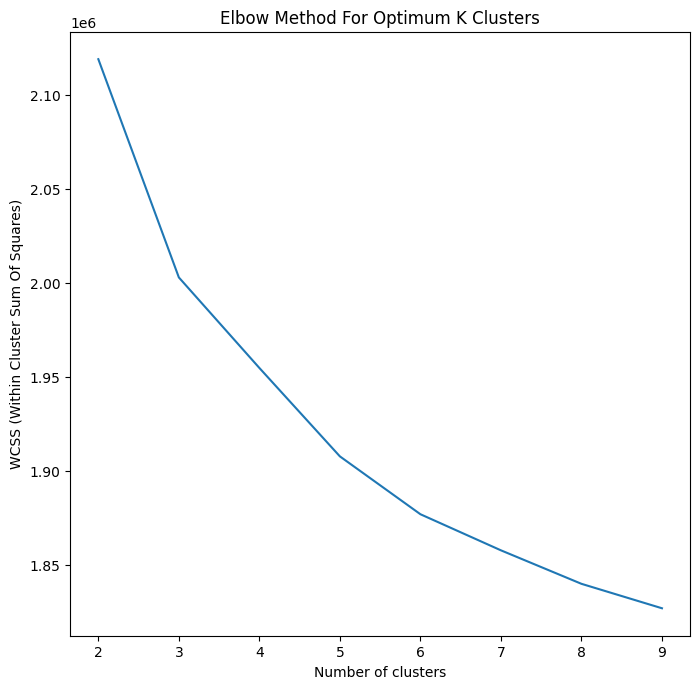

In [147]:
# Produces wcss graph for evaluation of appropriate value of K
# https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

plt.plot(range(kMin, kMax), wcss)
plt.title('Elbow Method For Optimum K Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum Of Squares)')
plt.show()